In [878]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA

try:
    import umap
except ImportError:
    %pip install umap-learn
    import umap

from copy import deepcopy

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

In [879]:
# Define the path to the directory containing the CSV files.
folder_path = r'C:\Users\rkaur02\Downloads\kaggle2024\kaggle2024\data'

# Create an empty dictionary to store the DataFrames.
# Each key-value pair within the dictionary will correspond to a filename and its associated DataFrame.
dataframes = {}

# Loop through each file in the specified directory.
for filename in os.listdir(folder_path):
    # Check if the current file has a .csv extension, indicating it's a CSV file.
    if filename.endswith('.csv'):
        # Construct the complete file path by joining the folder path and file name.
        file_path = os.path.join(folder_path, filename)
        
        # Read the CSV file into a DataFrame.
        # 'low_memory=False' disables the warning on mixed data types to infer data types over the entire column.
        df = pd.read_csv(file_path, low_memory=False)
        
        # Add the DataFrame to the dictionary.
        # The 'replace' method is used to clean up the filename to use as a key.
        # For example, it removes the "Kaggle Competition " prefix and the ".csv" suffix from the filename.
        dataframes[filename.replace("Kaggle Competition ", "").replace(".csv", "")] = df

# Print a message to indicate that all data has been successfully loaded into the DataFrames.
print("All data is loaded")

All data is loaded


In [880]:
# Go through each of the loaded datasets and see how they look like
for dd in list(dataframes):
    print(f"{dd}:")
    display(dataframes[dd].head(3))

Product Data:


,product_id,productname,producttype,family,superfamily,productgroup,productsubgroup,productstrategy,sbuname
0,9902,PGGM Strategy 1 Japan Index - SPCB00076,Databases,Benchmarks - Equity - S&P Dow Jones,Benchmark Services,Benchmarks/Constituents,Custom,PLC - Analytics Services,PLC Solutions
1,11063,MSCI Custom World/Materials SWIB Taxes Index -...,Databases,Benchmarks - Equity - MSCI,Benchmark Services,Benchmarks/Constituents,Custom,PLC - Analytics Services,PLC Solutions
2,16608,NASDAQ Singularity Index,Databases,FactSet DataFeed - Ownership,Markets,Benchmarks/Constituents,Other - Benchmarks/Constitutents,Data Solutions,Data Solutions


Support Case Data:


,account_id,TicketId,CaseNumber,Problem,Origin,IntentSource,Intent,SubIntent,PrimaryProduct,SecondaryProduct,...,FirmDescription,SupportModel,IsDeleted,IsClosed,IsEscalated,IsDirectConsultingCase,NbrOfCaseOwners,AgeInHours,QueueCount,isNonSupportCase
0,2528307,7806961,7806961,Formula to pull fiscal year end of a company.,FactSet Support,General Support,Formulas,Formula Requested / Given / Built,FactSet Fundamentals,Unknown,...,Banking & Advisory,Full Account Team,False,True,False,False,1,60449,0,False
1,2528307,7806913,7806913,1. Could I please have the formula for the fol...,FactSet Support,General Support,Formulas,Formula Requested / Given / Built,FactSet Equity Capital Structure,FactSet Prices (IDC/Exshare),...,Banking & Advisory,Full Account Team,False,True,False,False,1,60472,0,False
2,2251200,7961864,7961864,Please update Broker Detailed Estimates Templa...,Direct,Direct Support,Formulas,Template Built/Refreshed,Company/Security - Estimates,Unknown,...,Corporate,Outbound Support,False,True,False,False,2,19647,1,False


Test Labels:


,account_id,trial_start_date,trial_end_date,prediction_date,trial_outcome,year_month
0,3476,2023-05-18,2023-08-14,2023-06-02,Unknown,2023-05
1,173027,2023-09-25,2023-10-15,2023-10-10,Unknown,2023-09
2,316974,2023-05-18,2023-08-14,2023-06-02,Unknown,2023-05


Train Labels:


,account_id,trial_start_date,trial_end_date,prediction_date,trial_outcome,year_month
0,2135,2022-12-21,2023-01-20,2023-01-05,Failed,2022-12
1,179070,2022-08-24,2022-09-26,2022-09-08,Failed,2022-08
2,238977,2023-04-27,2023-05-14,2023-05-12,Failed,2023-04


Usage Data:


,user_id,account_id,product_id,Date,Hits
0,1518946,2135,21345.0,2023-01-03,1.0
1,1518946,2135,7106.0,2023-01-03,1.0
2,1518946,2135,14595.0,2023-01-03,1.0


User Data:


,user_id,account_id,workstation_product,position,userclass,trial_start_date,trial_end_date,prediction_date
0,1518946,2135,APB - Wealth Manager - Premier,Wealth Manager,Wealth/Advisory,2022-12-21,2023-01-20,2023-01-05
1,1518947,2135,APB - Wealth Manager - Premier,Wealth Manager,Wealth/Advisory,2022-12-21,2023-01-20,2023-01-05
2,1677621,173027,Sell-Side Flagship Workstation,Managing Director,Investment Banking,2023-09-25,2023-10-15,2023-10-10


In [881]:
print(dataframes["Train Labels"].columns)

Index(['account_id', 'trial_start_date', 'trial_end_date', 'prediction_date',
       'trial_outcome', 'year_month'],
      dtype='object')


In [882]:
def prep_data(data_labels, dataframes):
    # Create a deep copy of the `data_labels` DataFrame to avoid modifying the original data.
    labels = deepcopy(data_labels)
    
    # Convert the date columns to datetime objects to enable date-based operations.
    # This makes it easy to handle dates and manipulate them later on.
    labels['trial_start_date'] = pd.to_datetime(labels['trial_start_date'])
    labels['trial_end_date'] = pd.to_datetime(labels['trial_end_date'])
    labels['prediction_date'] = pd.to_datetime(labels['prediction_date'])

    # Remove any timezone information from the datetime objects to standardize them.
    labels['trial_start_date'] = labels['trial_start_date'].dt.tz_localize(None)
    labels['trial_end_date'] = labels['trial_end_date'].dt.tz_localize(None)
    labels['prediction_date'] = labels['prediction_date'].dt.tz_localize(None)

    # Repeat the same process for the "User Data" DataFrame.
    users = deepcopy(dataframes["User Data"])
    users['trial_start_date'] = pd.to_datetime(users['trial_start_date'])
    users['trial_end_date'] = pd.to_datetime(users['trial_end_date'])
    users['prediction_date'] = pd.to_datetime(users['prediction_date'])

    users['trial_start_date'] = users['trial_start_date'].dt.tz_localize(None)
    users['trial_end_date'] = users['trial_end_date'].dt.tz_localize(None)
    users['prediction_date'] = users['prediction_date'].dt.tz_localize(None)

    # Process the "Usage Data" DataFrame by converting the 'Date' column to datetime
    # and normalizing the timezone information.
    usage = dataframes["Usage Data"]
    usage['Date'] = pd.to_datetime(usage['Date'])
    usage['Date'] = usage['Date'].dt.tz_localize(None)

    # Merge the 'labels' DataFrame with 'users' DataFrame based on common columns.
    # The 'how="left"' argument specifies a left join, keeping all rows from 'labels'.
    output = pd.merge(labels, users, how="left", on=["account_id", "trial_start_date", "trial_end_date", "prediction_date"])
    
    # Merge the updated 'output' DataFrame with the 'usage' DataFrame based on the 'account_id' and 'user_id' columns.
    output = pd.merge(output, usage, how="left", on=["account_id", "user_id"])
    
    # Filter the 'output' DataFrame to only include records where the 'Date' is within the trial period and before the 'prediction_date'.
    output = output[(output["trial_start_date"] <= output["Date"]) & (output["prediction_date"] > output["Date"])]

    # Merge the 'output' DataFrame with the "Product Data" DataFrame on the 'product_id' column.
    output = pd.merge(output, dataframes["Product Data"], how="left", on=["product_id"])

    # Return the fully merged and filtered DataFrame.
    return output

In [883]:
def create_features(data_labels, dataframes):
    # Prepare the data by merging different sources and filtering based on the dates
    data = prep_data(data_labels, dataframes)

    # Compute features that summarize the general statistics of users' and products' interaction within the trial period.
    # Group the data by 'account_id', and calculate the number of unique users (num_users), unique products (num_products), 
    # and the number of active days (Num Active Days).
    general_stats = data.groupby("account_id").agg(
        num_users=("user_id", "nunique"),
        num_products=("product_id", "nunique"),
        Num_Active_Days=("Date", "nunique")
    ).reset_index()
    
    # Compute additional features specific to applications.
    # Filter for interactions with 'Applications', then group by 'account_id' and count unique products and active days related to applications.
    application_use = data[data["producttype"] == "Applications"].groupby("account_id").agg(
        num_application_products=("product_id", "nunique"),
        Num_Active_Days_for_Application_Products=("Date", "nunique")
    ).reset_index()
    
    # Process the "Support Case Data" to count the number of support cases opened during the trial.
    # Convert date columns to datetime objects and remove timezone information as done previously.
    support = deepcopy(dataframes["Support Case Data"])
    for column in ['OpenedDate', 'ClosedDate', 'LastActivityDate', 'LastModifiedDate']:
        support[column] = pd.to_datetime(support[column]).dt.tz_localize(None)
    
    # Merge the labels DataFrame with the support DataFrame and filter for records where support cases were opened during the trial period.
    support = pd.merge(data_labels, support, how="left", on="account_id")
    support = support[(support["trial_start_date"] <= support["OpenedDate"]) & (support["prediction_date"] > support["OpenedDate"])]
    
    # Group by 'account_id' and count the number of unique TicketId as support cases opened.
    support_stats = support.groupby("account_id").agg(
        Number_Support_Cases_Opened=("TicketId", "nunique")
    ).reset_index()

    output = data_labels[["account_id", "trial_outcome", "trial_start_date", "trial_end_date"]] #added trial_start_date and trial_end_date

    output = output.merge(general_stats, how="left", on="account_id")
    output = output.merge(application_use, how="left", on="account_id")
    output = output.merge(support_stats, how="left", on="account_id")

    # Fill any missing values with 0, assuming that an absence of recorded activity implies zero activity.
    feature_columns = ["num_users", 'num_products', 'Num_Active_Days',
                       'num_application_products', 
                       'Num_Active_Days_for_Application_Products',
                       'Number_Support_Cases_Opened']
    
    for feature in feature_columns:
        output[feature] = output[feature].fillna(0)
    
    # Return the final DataFrame with the generated features.
    return output

In [884]:
# Create a featurized training and testing dataset
train_data = create_features(dataframes["Train Labels"], dataframes)
test_data  = create_features(dataframes["Test Labels"], dataframes)
display(train_data.head())

,account_id,trial_outcome,trial_start_date,trial_end_date,num_users,num_products,Num_Active_Days,num_application_products,Num_Active_Days_for_Application_Products,Number_Support_Cases_Opened
0,2135,Failed,2022-12-21,2023-01-20,2.0,19.0,3.0,19.0,3.0,0.0
1,179070,Failed,2022-08-24,2022-09-26,1.0,20.0,7.0,18.0,7.0,1.0
2,238977,Failed,2023-04-27,2023-05-14,2.0,29.0,9.0,27.0,8.0,0.0
3,255192,Client,2023-04-25,2023-05-20,0.0,0.0,0.0,0.0,0.0,0.0
4,272851,Client,2022-12-19,2023-01-31,2.0,28.0,1.0,27.0,1.0,0.0


In [885]:
#converting trial_start_date and end_date to datetime values

train_data['trial_start_date'] = pd.to_datetime(train_data['trial_start_date'])
train_data['trial_end_date'] = pd.to_datetime(train_data['trial_end_date'])

test_data['trial_start_date'] = pd.to_datetime(test_data['trial_start_date'])
test_data['trial_end_date'] = pd.to_datetime(test_data['trial_end_date'])

In [886]:
#creating new feature, trial_length using start and end date
deltatrain = train_data["trial_end_date"] - train_data["trial_start_date"]
train_data["trial_length"] = deltatrain.dt.days

#repeat on test data
deltatest = test_data["trial_end_date"] - test_data["trial_start_date"]
test_data["trial_length"] = deltatest.dt.days

#drop these two values as they won't be any more use to us
train_data.drop(['trial_start_date', 'trial_end_date'], axis=1, inplace=True)
test_data.drop(['trial_start_date', 'trial_end_date'], axis=1, inplace=True)

train_data.head()

,account_id,trial_outcome,num_users,num_products,Num_Active_Days,num_application_products,Num_Active_Days_for_Application_Products,Number_Support_Cases_Opened,trial_length
0,2135,Failed,2.0,19.0,3.0,19.0,3.0,0.0,30
1,179070,Failed,1.0,20.0,7.0,18.0,7.0,1.0,33
2,238977,Failed,2.0,29.0,9.0,27.0,8.0,0.0,17
3,255192,Client,0.0,0.0,0.0,0.0,0.0,0.0,25
4,272851,Client,2.0,28.0,1.0,27.0,1.0,0.0,43


In [887]:
#calculating percentage of active days
train_data['perc_of_active_days'] =round((train_data['Num_Active_Days'] / train_data['trial_length']), 2)
test_data['perc_of_active_days'] =round((test_data['Num_Active_Days'] / test_data['trial_length']), 2)

train_data.head()

,account_id,trial_outcome,num_users,num_products,Num_Active_Days,num_application_products,Num_Active_Days_for_Application_Products,Number_Support_Cases_Opened,trial_length,perc_of_active_days
0,2135,Failed,2.0,19.0,3.0,19.0,3.0,0.0,30,0.10
1,179070,Failed,1.0,20.0,7.0,18.0,7.0,1.0,33,0.21
2,238977,Failed,2.0,29.0,9.0,27.0,8.0,0.0,17,0.53
3,255192,Client,0.0,0.0,0.0,0.0,0.0,0.0,25,0.00
4,272851,Client,2.0,28.0,1.0,27.0,1.0,0.0,43,0.02


In [888]:
#creating a function which allows me to easily create new features
def create_new_feature(feature_name, feature_one, feature_two, multiply):
    #if multiply=True, multiply the last two parameters.
    if (multiply):
        train_data[feature_name] = train_data.apply(lambda row: round((row[feature_one] * row[feature_two]), 2) if row[feature_two] != 0 else 0, axis=1)
        test_data[feature_name] = test_data.apply(lambda row: round((row[feature_two] * row[feature_two]), 2) if row[feature_two] != 0 else 0, axis=1)
    else:
        #if multiply=False, divide the last to numbers 
        train_data[feature_name] = train_data.apply(lambda row: round((row[feature_one] / row[feature_two]), 2) if row[feature_two] != 0 else 0, axis=1)
        test_data[feature_name] = test_data.apply(lambda row: round((row[feature_two] / row[feature_two]), 2) if row[feature_two] != 0 else 0, axis=1)
    #fill any missing values with 0 
    train_data[feature_name].fillna(0, inplace=True)
    test_data[feature_name].fillna(0, inplace=True)

    return feature_name

In [889]:
#using function to create products_per_day feature
create_new_feature('products_per_day', 'num_application_products', 'Num_Active_Days', False)

train_data.head()

,account_id,trial_outcome,num_users,num_products,Num_Active_Days,num_application_products,Num_Active_Days_for_Application_Products,Number_Support_Cases_Opened,trial_length,perc_of_active_days,products_per_day
0,2135,Failed,2.0,19.0,3.0,19.0,3.0,0.0,30,0.10,6.33
1,179070,Failed,1.0,20.0,7.0,18.0,7.0,1.0,33,0.21,2.57
2,238977,Failed,2.0,29.0,9.0,27.0,8.0,0.0,17,0.53,3.00
3,255192,Client,0.0,0.0,0.0,0.0,0.0,0.0,25,0.00,0.00
4,272851,Client,2.0,28.0,1.0,27.0,1.0,0.0,43,0.02,27.00


<Axes: >

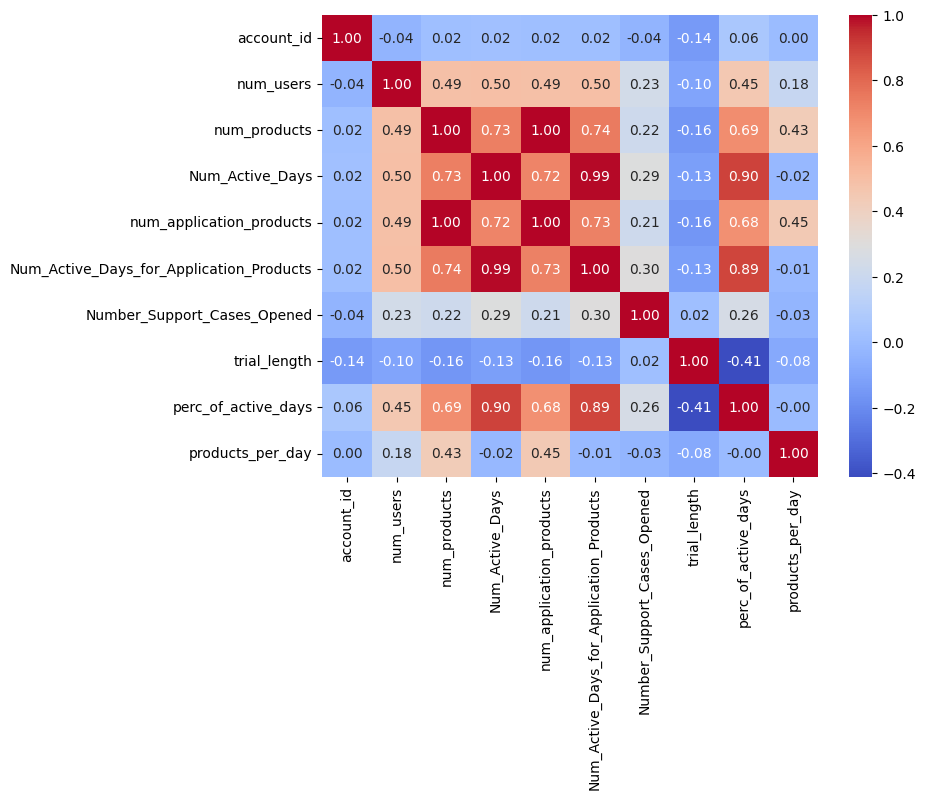

In [890]:
#create heatmap to visualize correlations

import seaborn as sns

correlation_matrix = train_data.corr(numeric_only=True)

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

In [891]:
#dropping correlated variables
train_data.drop(['Num_Active_Days_for_Application_Products', 'num_products'], axis=1, inplace=True)
test_data.drop(['Num_Active_Days_for_Application_Products', 'num_products'], axis=1, inplace=True)

train_data.head()

,account_id,trial_outcome,num_users,Num_Active_Days,num_application_products,Number_Support_Cases_Opened,trial_length,perc_of_active_days,products_per_day
0,2135,Failed,2.0,3.0,19.0,0.0,30,0.10,6.33
1,179070,Failed,1.0,7.0,18.0,1.0,33,0.21,2.57
2,238977,Failed,2.0,9.0,27.0,0.0,17,0.53,3.00
3,255192,Client,0.0,0.0,0.0,0.0,25,0.00,0.00
4,272851,Client,2.0,1.0,27.0,0.0,43,0.02,27.00


In [892]:
#converting trial_outcome value to 0 or 1 for convinience
le = LabelEncoder()

train_data['trial_outcome'] = le.fit_transform(train_data['trial_outcome'])
test_data['trial_outcome'] = le.fit_transform(test_data['trial_outcome'])

In [893]:
#bin num_users value into 8 equal sized parts
labels = [0, 1, 2, 3, 4, 5, 6, 7]
bins = [0, 1.25, 2.5, 3.75, 5, 6.25, 7.5, 8.75, 10]
train_data['user_normalized'] = pd.cut(train_data['num_users'], bins=bins, labels=labels, include_lowest=True)
test_data['user_normalized'] = pd.cut(test_data['num_users'], bins=bins, labels=labels, include_lowest=True)

train_data.head()

,account_id,trial_outcome,num_users,Num_Active_Days,num_application_products,Number_Support_Cases_Opened,trial_length,perc_of_active_days,products_per_day,user_normalized
0,2135,1,2.0,3.0,19.0,0.0,30,0.10,6.33,1
1,179070,1,1.0,7.0,18.0,1.0,33,0.21,2.57,0
2,238977,1,2.0,9.0,27.0,0.0,17,0.53,3.00,1
3,255192,0,0.0,0.0,0.0,0.0,25,0.00,0.00,0
4,272851,0,2.0,1.0,27.0,0.0,43,0.02,27.00,1


In [894]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

In [895]:
df = deepcopy(train_data)

df.set_index('account_id', inplace=True)
X = df.drop('trial_outcome', axis=1) # Drop the column 'trial_outcome' from the features y = df['trial_outcome'] # Extract the 'trial_outcome' column as the target variable
y = df['trial_outcome']    

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize KFold
kfold = KFold(n_splits=3, shuffle=True, random_state=126)

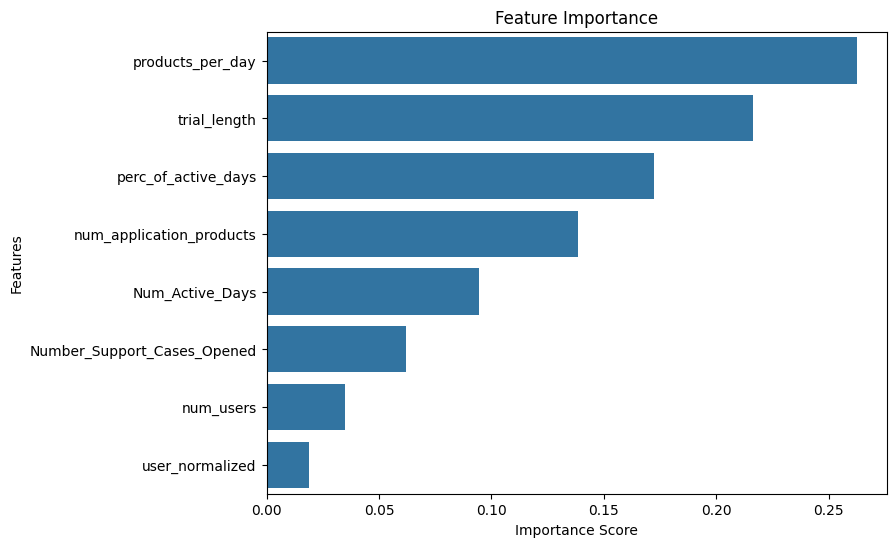

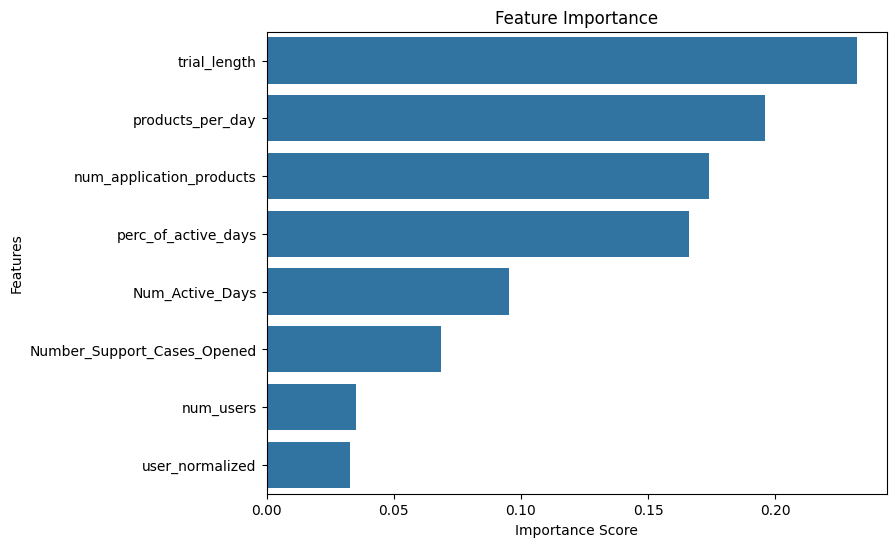

In [896]:
model = GradientBoostingClassifier()
model.fit(X, y) # 'X' are the features and 'y' is the target.

# Calculate feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Create and plot the Feature importance plot
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

model = RandomForestClassifier()
model.fit(X, y) # 'X' are the features and 'y' is the target.

# Calculate feature importance
feature_importance = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Create and plot the Feature importance plot
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importance, y=feature_importance.index)
plt.title('Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()

In [897]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

In [898]:
# Initialize KFold
kfold = KFold(n_splits=3, shuffle=True, random_state=126)

# Initialize models, trying out more models such as KNN and Support Vector Machines
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=300, max_depth=2),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, max_depth=2),
    "SVM": SVC(),
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "AdaBoost": AdaBoostClassifier(n_estimators=100),
    "Gaussian Naive Bayes": GaussianNB()
}

# Dictionary to hold model performance results
model_performance = {}

# Train each model and evaluate performance
for model_name, model in models.items():
    model.fit(X_train, y_train)
    # Generate predictions using cross-validation
    y_pred_cv = model.predict(X_test)

    # Compute the accuracy, precision, recall, and F1 score
    accuracy_cv = accuracy_score(y_test, y_pred_cv)
    precision_cv = precision_score(y_test, y_pred_cv, average='macro')
    recall_cv = recall_score(y_test, y_pred_cv, average='macro')
    f1_cv = f1_score(y_test, y_pred_cv, average='macro')

    # Store the results
    model_performance[model_name] = {
        "Accuracy": np.round(accuracy_cv, 2),
        "Precision": np.round(precision_cv, 2),
        "Recall": np.round(recall_cv, 2),
        "F1 Score": np.round(f1_cv, 2)
    }


model_performance = pd.DataFrame(model_performance)
display(model_performance)

,Decision Tree,Random Forest,Gradient Boosting,SVM,Logistic Regression,KNN,AdaBoost,Gaussian Naive Bayes
Accuracy,0.61,0.68,0.69,0.67,0.71,0.68,0.69,0.66
Precision,0.56,0.84,0.63,0.34,0.68,0.62,0.64,0.60
Recall,0.56,0.51,0.57,0.50,0.58,0.60,0.59,0.59
F1 Score,0.56,0.42,0.56,0.40,0.56,0.60,0.59,0.59


Accuracy: 0.69


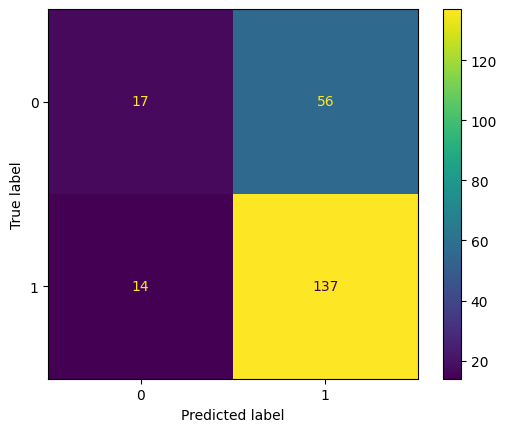

In [899]:
#Baseline GB model

gtree = GradientBoostingClassifier(n_estimators=100, max_depth=2)
gtree.fit(X_train, y_train)
y_pred = gtree.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=gtree.classes_)

In [900]:
from sklearn.model_selection import cross_val_score

#function to develop model report
def modelfit(alg, dtrain, target, predictors, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], target)
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, dtrain[predictors], target, cv=cv_folds, scoring='roc_auc')
    
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(target.values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(target, dtrain_predprob))
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.802
AUC Score (Train): 0.866525
CV Score : Mean - 0.6147728 | Std - 0.05968577 | Min - 0.5104976 | Max - 0.6900345


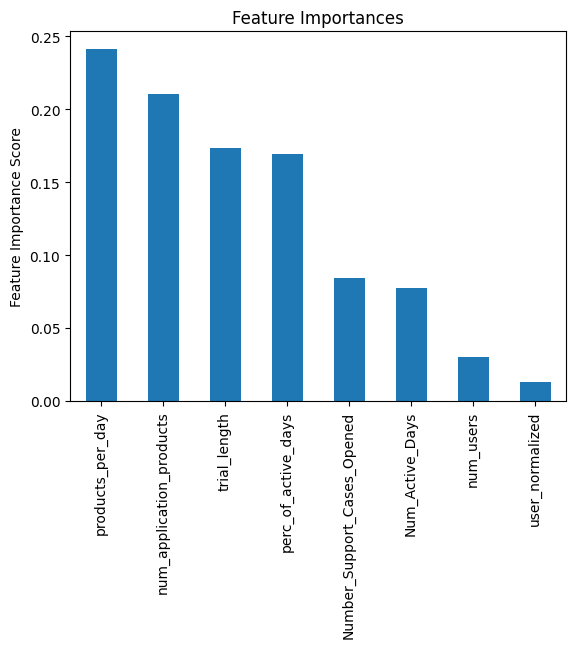

In [901]:
#define target and id column so we don't include those in our model
target = 'trial_outcome'
IDcol = 'account_id'
predictors = [x for x in X_train.columns if x not in [target, IDcol]]

#baseline model (the one we are going to build off of)
gbm0 = GradientBoostingClassifier(random_state=10)
modelfit(gbm0, X_train, y_train, predictors)

In [902]:
#Grid Search for n_estimators
from sklearn.model_selection import GridSearchCV

predictors = [x for x in X_train.columns if x not in [target, IDcol]]
param_test1 = {'n_estimators':range(20,81,10)} #param grid
 
#apply Grid Search
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 81, 10)},
             scoring='roc_auc')

In [903]:
#print out results to get ideal values

print("Best parameters set found on development set:")
print(gsearch1.best_params_)

print("\nBest score found on development set:")
print(gsearch1.best_score_)

print("\nGrid scores on development set:")
means = gsearch1.cv_results_['mean_test_score']
stds = gsearch1.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsearch1.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))

Best parameters set found on development set:
{'n_estimators': 50}

Best score found on development set:
0.6324080017115961

Grid scores on development set:
0.623 (+/-0.084) for {'n_estimators': 20}
0.628 (+/-0.093) for {'n_estimators': 30}
0.628 (+/-0.106) for {'n_estimators': 40}
0.632 (+/-0.092) for {'n_estimators': 50}
0.629 (+/-0.092) for {'n_estimators': 60}
0.629 (+/-0.095) for {'n_estimators': 70}
0.629 (+/-0.098) for {'n_estimators': 80}



Model Report
Accuracy : 0.7092
AUC Score (Train): 0.680727
CV Score : Mean - 0.632408 | Std - 0.0462477 | Min - 0.5609002 | Max - 0.7001726


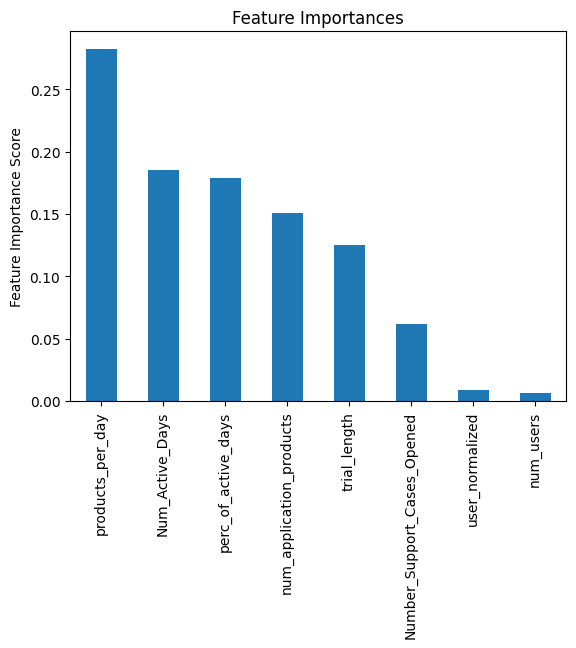

In [904]:
#run modelfit() to receive CV score, accuracy and AUC score
modelfit(gsearch1.best_estimator_, X_train, y_train, predictors)

In [905]:
#Repeat Grid Search for max_Depth and min_samples_split

param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_features='sqrt',
                                                  n_estimators=60,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': range(5, 16, 2),
                         'min_samples_split': range(200, 1001, 200)},
             scoring='roc_auc')

In [906]:
#show results
print("Best parameters set found on development set:")
print(gsearch2.best_params_)

print("\nBest score found on development set:")
print(gsearch2.best_score_)

print("\nGrid scores on development set:")
means = gsearch2.cv_results_['mean_test_score']
stds = gsearch2.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsearch2.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))

Best parameters set found on development set:
{'max_depth': 5, 'min_samples_split': 200}

Best score found on development set:
0.6157219818839381

Grid scores on development set:
0.616 (+/-0.104) for {'max_depth': 5, 'min_samples_split': 200}
0.613 (+/-0.096) for {'max_depth': 5, 'min_samples_split': 400}
0.500 (+/-0.000) for {'max_depth': 5, 'min_samples_split': 600}
0.500 (+/-0.000) for {'max_depth': 5, 'min_samples_split': 800}
0.500 (+/-0.000) for {'max_depth': 5, 'min_samples_split': 1000}
0.614 (+/-0.099) for {'max_depth': 7, 'min_samples_split': 200}
0.610 (+/-0.093) for {'max_depth': 7, 'min_samples_split': 400}
0.500 (+/-0.000) for {'max_depth': 7, 'min_samples_split': 600}
0.500 (+/-0.000) for {'max_depth': 7, 'min_samples_split': 800}
0.500 (+/-0.000) for {'max_depth': 7, 'min_samples_split': 1000}
0.610 (+/-0.109) for {'max_depth': 9, 'min_samples_split': 200}
0.609 (+/-0.092) for {'max_depth': 9, 'min_samples_split': 400}
0.500 (+/-0.000) for {'max_depth': 9, 'min_samples_


Model Report
Accuracy : 0.7629
AUC Score (Train): 0.802886
CV Score : Mean - 0.615722 | Std - 0.05221443 | Min - 0.5184067 | Max - 0.6738568


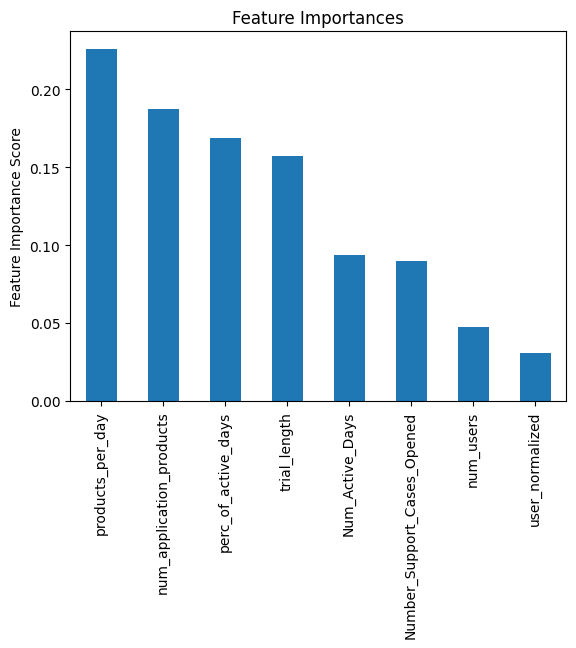

In [907]:
#run modelfit()
modelfit(gsearch2.best_estimator_, X_train, y_train, predictors)

In [908]:
#Grid Search CV on min_samples_split and leaf
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=9,
                                                  max_features='sqrt',
                                                  n_estimators=60,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'min_samples_leaf': range(30, 71, 10),
                         'min_samples_split': range(1000, 2100, 200)},
             scoring='roc_auc')

In [909]:
#print results

print("Best parameters set found on development set:")
print(gsearch3.best_params_)

print("\nBest score found on development set:")
print(gsearch3.best_score_)

print("\nGrid scores on development set:")
means = gsearch3.cv_results_['mean_test_score']
stds = gsearch3.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsearch3.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))

Best parameters set found on development set:
{'min_samples_leaf': 30, 'min_samples_split': 1000}

Best score found on development set:
0.5

Grid scores on development set:
0.500 (+/-0.000) for {'min_samples_leaf': 30, 'min_samples_split': 1000}
0.500 (+/-0.000) for {'min_samples_leaf': 30, 'min_samples_split': 1200}
0.500 (+/-0.000) for {'min_samples_leaf': 30, 'min_samples_split': 1400}
0.500 (+/-0.000) for {'min_samples_leaf': 30, 'min_samples_split': 1600}
0.500 (+/-0.000) for {'min_samples_leaf': 30, 'min_samples_split': 1800}
0.500 (+/-0.000) for {'min_samples_leaf': 30, 'min_samples_split': 2000}
0.500 (+/-0.000) for {'min_samples_leaf': 40, 'min_samples_split': 1000}
0.500 (+/-0.000) for {'min_samples_leaf': 40, 'min_samples_split': 1200}
0.500 (+/-0.000) for {'min_samples_leaf': 40, 'min_samples_split': 1400}
0.500 (+/-0.000) for {'min_samples_leaf': 40, 'min_samples_split': 1600}
0.500 (+/-0.000) for {'min_samples_leaf': 40, 'min_samples_split': 1800}
0.500 (+/-0.000) for {'m

In [910]:
#Grid Search on max_features parameter

param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9, min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=9,
                                                  min_samples_leaf=60,
                                                  min_samples_split=1200,
                                                  n_estimators=60,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'max_features': range(7, 20, 2)},
             scoring='roc_auc')

In [911]:
#Show results

print("Best parameters set found on development set:")
print(gsearch4.best_params_)

print("\nBest score found on development set:")
print(gsearch4.best_score_)

print("\nGrid scores on development set:")
means = gsearch4.cv_results_['mean_test_score']
stds = gsearch4.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsearch4.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))

Best parameters set found on development set:
{'max_features': 7}

Best score found on development set:
0.5

Grid scores on development set:
0.500 (+/-0.000) for {'max_features': 7}
0.500 (+/-0.000) for {'max_features': 9}
0.500 (+/-0.000) for {'max_features': 11}
0.500 (+/-0.000) for {'max_features': 13}
0.500 (+/-0.000) for {'max_features': 15}
0.500 (+/-0.000) for {'max_features': 17}
0.500 (+/-0.000) for {'max_features': 19}


In [912]:
#Last test on subsample parameter

param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,min_samples_split=1200, min_samples_leaf=60, subsample=0.8, random_state=10,max_features=7),
param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=9, max_features=7,
                                                  min_samples_leaf=60,
                                                  min_samples_split=1200,
                                                  n_estimators=60,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4,
             param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
             scoring='roc_auc')

In [913]:
#Show results

print("Best parameters set found on development set:")
print(gsearch5.best_params_)

print("\nBest score found on development set:")
print(gsearch5.best_score_)

print("\nGrid scores on development set:")
means = gsearch5.cv_results_['mean_test_score']
stds = gsearch5.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gsearch5.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
            % (mean, std * 2, params))

Best parameters set found on development set:
{'subsample': 0.6}

Best score found on development set:
0.5

Grid scores on development set:
0.500 (+/-0.000) for {'subsample': 0.6}
0.500 (+/-0.000) for {'subsample': 0.7}
0.500 (+/-0.000) for {'subsample': 0.75}
0.500 (+/-0.000) for {'subsample': 0.8}
0.500 (+/-0.000) for {'subsample': 0.85}
0.500 (+/-0.000) for {'subsample': 0.9}



Model Report
Accuracy : 0.7092
AUC Score (Train): 0.680727
CV Score : Mean - 0.632408 | Std - 0.0462477 | Min - 0.5609002 | Max - 0.7001726


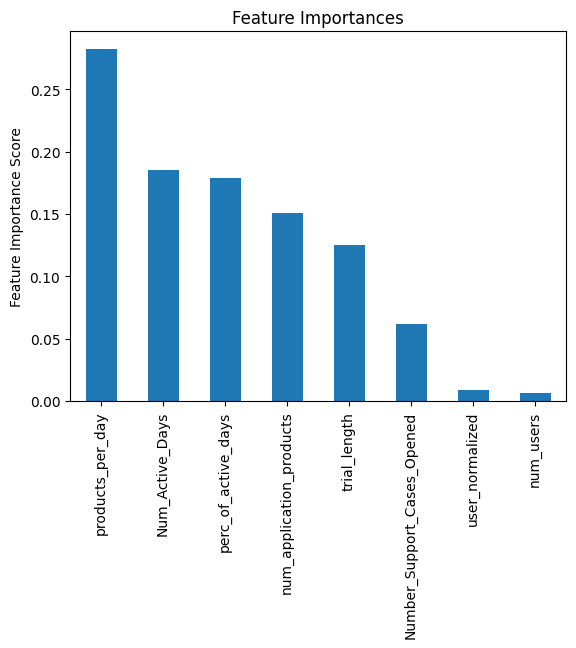

In [914]:
#Final model 1 (using parameters found)

predictors = [x for x in X_train.columns if x not in [target, IDcol]]
gbm_tuned_1 = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, min_samples_split=500,min_samples_leaf=50,max_depth=8, warm_start=True, max_features='sqrt',subsample=0.8,random_state=10)
modelfit(gbm_tuned_1, X_train, y_train, predictors)


Model Report
Accuracy : 0.7125
AUC Score (Train): 0.681421
CV Score : Mean - 0.6293283 | Std - 0.0512824 | Min - 0.5567299 | Max - 0.711461


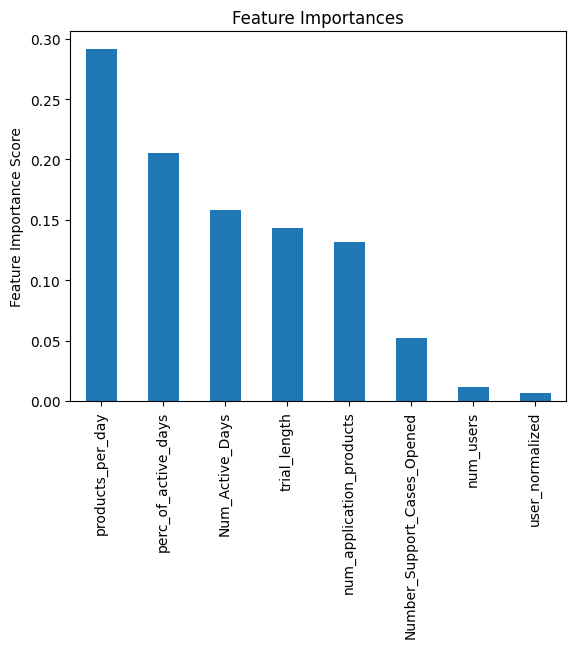

In [915]:
#Final model 2, modifying learning rate param and n_estimators proportionally

predictors = [x for x in X_train.columns if x not in [target, IDcol]]
gbm_tuned_2 = GradientBoostingClassifier(learning_rate=0.05, n_estimators=100, min_samples_split=500,min_samples_leaf=50,max_depth=8, warm_start=True, max_features='sqrt',subsample=0.8,random_state=10)
modelfit(gbm_tuned_2, X_train, y_train, predictors)


Model Report
Accuracy : 0.7159
AUC Score (Train): 0.682919
CV Score : Mean - 0.6287012 | Std - 0.04919245 | Min - 0.5556514 | Max - 0.702761


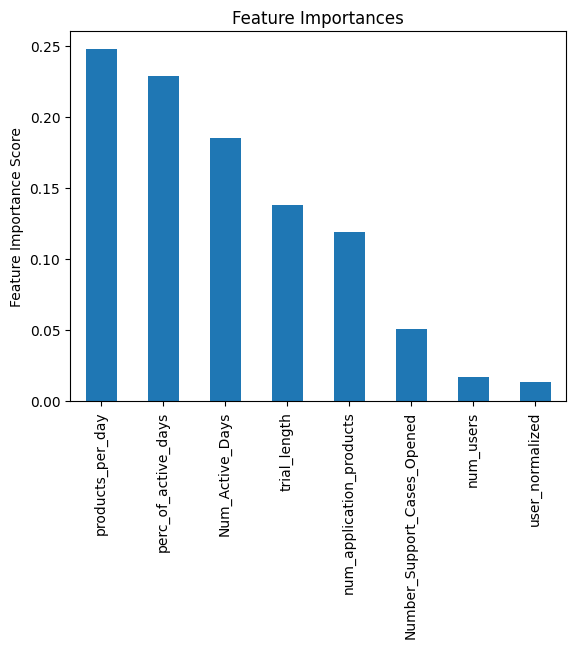

In [916]:
#Model test 3

predictors = [x for x in X_train.columns if x not in [target, IDcol]]
gbm_tuned_3 = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, min_samples_split=500,min_samples_leaf=50,max_depth=8, warm_start=True, max_features='sqrt',subsample=0.8,random_state=10)
modelfit(gbm_tuned_3, X_train, y_train, predictors)


Model Report
Accuracy : 0.7148
AUC Score (Train): 0.684043
CV Score : Mean - 0.6294825 | Std - 0.04989958 | Min - 0.552344 | Max - 0.704199


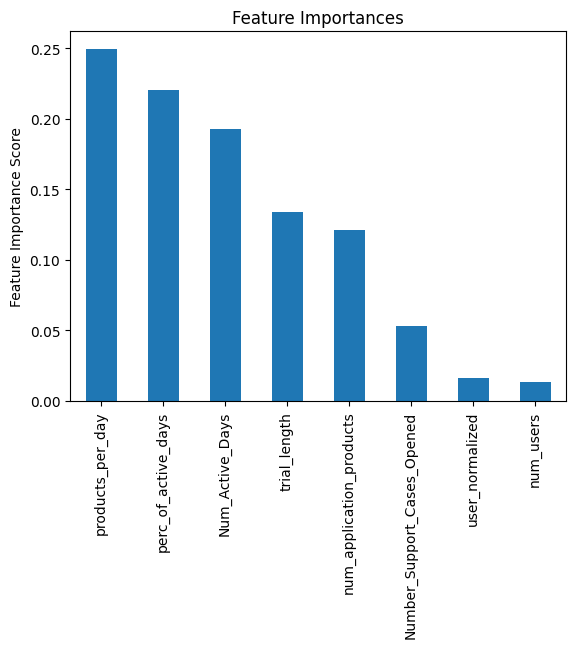

In [917]:
#Model test 4

predictors = [x for x in X_train.columns if x not in [target, IDcol]]
gbm_tuned_4 = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1000, min_samples_split=500,min_samples_leaf=50,max_depth=8, warm_start=True, max_features='sqrt',subsample=0.8,random_state=10)
modelfit(gbm_tuned_4, X_train, y_train, predictors)

In [918]:
#Fitting our models for the last time on the training data
gbm_tuned_1.fit(X_train, y_train)
gbm_tuned_2.fit(X_train, y_train)
gbm_tuned_3.fit(X_train, y_train)
gbm_tuned_4.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.005, max_depth=8,
                           max_features='sqrt', min_samples_leaf=50,
                           min_samples_split=500, n_estimators=1000,
                           random_state=10, subsample=0.8, warm_start=True)

In [919]:
#making predictions on test data to use for confusion matrix

predictions1 = gbm_tuned_1.predict(X_test)
predictions2 = gbm_tuned_2.predict(X_test)
predictions3 = gbm_tuned_3.predict(X_test)
predictions4 = gbm_tuned_4.predict(X_test)

Accuracy: 0.71


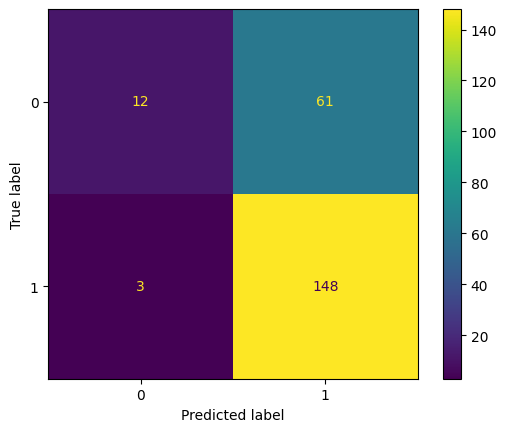

In [920]:
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

#evaluating predictions1, the best performing model on test data and showing it using a confusion matrix
y_pred = predictions1
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}")
cm_display = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=gtree.classes_)

In [921]:
from sklearn.preprocessing import LabelEncoder

# Prepare the testing feature matrix (X_test_data) by dropping the 'account_id' and 'trial_outcome' columns.
# We drop 'account_id' because it's an identifier, not a feature, and 'trial_outcome' because it's the target variable that we need to predict.
X_test_data = test_data.drop(['account_id', 'trial_outcome'], axis=1)

# Use the trained decision tree model (dtree) to predict the outcomes for the prepared testing feature matrix.
# Since 'dtree' is previously trained, we directly use it to make predictions here.

predicted_labels1 = gbm_tuned_1.predict(X_test_data)
predicted_labels2 = gbm_tuned_2.predict(X_test_data)
predicted_labels3 = gbm_tuned_1.predict(X_test_data)
predicted_labels4 = gbm_tuned_1.predict(X_test_data)

# Create a DataFrame 'final_results' containing each account's ID and the corresponding predicted outcome.
# This table will have two columns: 'account_id' and 'predicted_label', where 'predicted_label' is the prediction
# made by our decision tree model for each account.
final_results = pd.DataFrame({
    'account_id': test_data['account_id'],
    'predicted_label': predicted_labels
})


# Fit label encoder
le = LabelEncoder().fit(['Failed', 'Client']) # use your original classes here

# Inverse transform predicted labels
final_results['predicted_label'] = le.inverse_transform(final_results['predicted_label'])

display(final_results)

# Use the display function to visually show the 'final_results' DataFrame, which is especially useful in
# Jupyter Notebooks or other interactive environments that support rich display capabilities.
display(final_results)

,account_id,predicted_label
0,3476,Failed
1,173027,Failed
2,316974,Failed
3,451115,Failed
4,536768,Failed
...,...,...
533,2654419,Failed
534,2655147,Client
535,2656012,Client
536,2657106,Failed


,account_id,predicted_label
0,3476,Failed
1,173027,Failed
2,316974,Failed
3,451115,Failed
4,536768,Failed
...,...,...
533,2654419,Failed
534,2655147,Client
535,2656012,Client
536,2657106,Failed


In [922]:
print(",".join(list(final_results["predicted_label"])))

Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Client,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Client,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Client,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Client,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Client,Failed,Failed,Failed,Failed,Failed,Client,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Client,Failed,Client,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Failed,Client,Failed,Failed,Failed,Failed,Failed